In [1]:
# Check loaded modules
! module list
! python3 -m venv mofa_venv
! source mofa_venv/bin/activate

# Upgrade pip
! pip3 install --upgrade pip setuptools wheel

# Verify you're using the virtual environment
! which python  # Should show path with mofa_venv


Currently Loaded Modules:
  1) stack/2024-05   3) cuda/12.2.1          5) eth_proxy   7) hdf5/1.14.3
  2) gcc/13.2.0      4) python/3.11.6_cuda   6) r/4.3.2     8) julia/1.10.3

 

Defaulting to user installation because normal site-packages is not writeable
/cluster/software/stacks/2024-05/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-13.2.0/python-3.11.6-m4n2ny4dwaqmeobuqquo3gpyw2bct67i/bin/python


In [2]:
! export PATH=/cluster/home/taekim/.local/bin:$PATH
! echo 'export PATH=/cluster/home/taekim/.local/bin:$PATH' >> ~/.bashrc

# 2. Clean up the corrupted numpy
! rm -rf /cluster/home/taekim/.local/lib/python3.11/site-packages/~umpy*

# 3. Create a clean virtual environment (RECOMMENDED)
! python -m venv ~/mofa_clean_env
! source ~/mofa_clean_env/bin/activate

! pip3 install mofapy2

# 5. Test it works
! python -c "import mofapy2; import numpy; print('MOFA is ready!')"

Defaulting to user installation because normal site-packages is not writeable
MOFA is ready!


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os

In [69]:
# Analze data distribution for potential preprocessing steps

def check_mofa_data_distributions(expr_df, oxid_df):
    """
    Quick check of data distributions to verify likelihood choices
    Does NOT modify data - just reports findings
    """
    print("\n" + "="*80)
    print("DATA DISTRIBUTION CHECK FOR MOFA")
    print("="*80)
    
    # Expression data check
    print("\nEXPRESSION DATA:")
    expr_vals = expr_df['Expression_level'].dropna().values
    
    print(f"  Range: [{expr_vals.min():.3f}, {expr_vals.max():.3f}]")
    print(f"  Mean: {expr_vals.mean():.3f}, Median: {np.median(expr_vals):.3f}")
    print(f"  Contains integers only: {np.all(expr_vals == expr_vals.astype(int))}")
    print(f"  Has negative values: {np.any(expr_vals < 0)}")
    
    # Normality test
    if len(expr_vals) > 8:
        _, p_val = stats.normaltest(expr_vals)
        print(f"  Normality test p-value: {p_val:.4f} {'(Normal)' if p_val > 0.05 else '(Not normal)'}")
    
    # Oxidation data check
    print("\nOXIDATION DATA:")
    oxid_vals = oxid_df['median_normalized_damage'].dropna().values
    
    print(f"  Range: [{oxid_vals.min():.3f}, {oxid_vals.max():.3f}]")
    print(f"  Mean: {oxid_vals.mean():.3f}, Median: {np.median(oxid_vals):.3f}")
    print(f"  Unique values: {len(np.unique(oxid_vals))}")
    
    # Normality test
    if len(oxid_vals) > 8:
        _, p_val = stats.normaltest(oxid_vals)
        print(f"  Normality test p-value: {p_val:.4f} {'(Normal)' if p_val > 0.05 else '(Not normal)'}")
    
    print("\nCURRENT SETTING: likelihoods=['gaussian', 'gaussian']")
    print("This is appropriate for normalized continuous data")
    print("="*80)


def visualize_distributions(expr_df, oxid_df):
    """
    Optional: Create distribution plots without modifying data
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Expression histogram
    expr_vals = expr_df['Expression_level'].dropna().values
    axes[0].hist(expr_vals, bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0].set_title('Expression Distribution')
    axes[0].set_xlabel('Expression Level')
    axes[0].set_ylabel('Frequency')
    axes[0].axvline(expr_vals.mean(), color='red', linestyle='--', label=f'Mean: {expr_vals.mean():.2f}')
    axes[0].legend()
    
    # Oxidation histogram
    oxid_vals = oxid_df['median_normalized_damage'].dropna().values
    axes[1].hist(oxid_vals, bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[1].set_title('Oxidation Damage Distribution')
    axes[1].set_xlabel('Normalized Damage')
    axes[1].set_ylabel('Frequency')
    axes[1].axvline(oxid_vals.mean(), color='red', linestyle='--', label=f'Mean: {oxid_vals.mean():.2f}')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

In [70]:
# Data specific helper functions

def extract_group_expr(sample):
    parts = sample.split('_')
    if len(parts) >= 3:
        return f"{parts[1]}_{parts[2]}"
    return "Unknown"

def extract_group_oxid(sample):
    parts = sample.split('_')
    if len(parts) >= 5:
        return f"{parts[2]}_{parts[3]}"
    return "Unknown"

def load_data(EXPR_PATH, OXID_PATH):
    print("Loading expression data...")
    expr_df = pd.read_csv(EXPR_PATH)
    
    print("Loading oxidation data...")
    oxid_df = pd.read_csv(OXID_PATH)
    
    expr_df['Group'] = expr_df['Sample'].apply(extract_group_expr)
    oxid_df['Group'] = oxid_df['sample'].apply(extract_group_oxid)
   
    return expr_df, oxid_df

def normalize_sample_names(sample_name, dataset_type='oxidation'):
    """
    Normalize sample names to match between datasets
    
    Expression format: '05_Ctrl_morning'
    Oxidation format:  'Sample_05_Ctrl_morning_S5_'
    Target format:     '05_Ctrl_morning'
    """
    if dataset_type == 'oxidation':
        # Remove 'Sample_' prefix and '_S#_' suffix
        if sample_name.startswith('Sample_'):
            # Remove 'Sample_' prefix
            clean_name = sample_name[7:]  # Remove first 7 characters
            
            # Remove '_S#_' suffix (find last occurrence of '_S' and remove everything after)
            if '_S' in clean_name:
                # Find the last '_S' pattern
                parts = clean_name.split('_S')
                if len(parts) > 1:
                    # Take everything before the last '_S'
                    clean_name = parts[0]
            
            return clean_name
        
    return sample_name  # Return unchanged if expression or doesn't match pattern

In [90]:
# Step 1

def prepare_real_mofa_data(expr_df, oxid_df):
    """
    Prepare data in the format required by real MOFA
    """
    print("\n" + "="*80)
    print("PREPARING DATA FOR REAL MOFA ANALYSIS")
    print("="*80)
    
    # Extract group information
    expr_df['Group'] = expr_df['Sample'].apply(extract_group_expr)
    oxid_df['Group'] = oxid_df['sample'].apply(extract_group_oxid)
    expr_df['Sample_normalized'] = expr_df['Sample'].apply(lambda x: normalize_sample_names(x, 'expression'))
    oxid_df['Sample_normalized'] = oxid_df['sample'].apply(lambda x: normalize_sample_names(x, 'oxidation'))
    
    gene_col_expr = 'Gene'
    gene_col_oxid = 'gene'
    
    # Find common groups and genes
    common_groups = expr_df['Group'].unique()
    common_genes = expr_df[gene_col_expr].unique()
    
    print(f"Common groups: {list(common_groups)}")
    print(f"Common genes: {len(common_genes):,}")
    
    # Prepare MOFA input format: list of matrices
    mofa_data = []
    sample_metadata = []
    
    for group in common_groups:
        print(f"\nProcessing group: {group}")
        
        # Expression data for this group
        expr_group = expr_df[
            (expr_df['Group'] == group) & 
            (expr_df[gene_col_expr].isin(common_genes))
        ]
        
        # Oxidation data for this group  
        oxid_group = oxid_df[
            (oxid_df['Group'] == group) & 
            (oxid_df[gene_col_oxid].isin(common_genes))
        ]
        
        if len(expr_group) == 0 or len(oxid_group) == 0:
            print(f"  Skipping {group} - no data")
            continue
            
        # Create pivot tables (features x samples)
        expr_pivot = expr_group.pivot_table(
            index=gene_col_expr,
            columns='Sample_normalized', 
            values='Expression_level',
            fill_value=0
        )
        
        oxid_pivot = oxid_group.pivot_table(
            index=gene_col_oxid,
            columns='Sample_normalized',
            values='median_normalized_damage',
            fill_value=np.nan
        )
        
        # Get common genes and samples
        common_genes_group = list(set(expr_pivot.index) & set(oxid_pivot.index))
        
        # Check samples using NORMALIZED names
        expr_samples_norm = set(expr_group['Sample_normalized'].unique())
        oxid_samples_norm = set(oxid_group['Sample_normalized'].unique())

        
        # Find common samples using normalized names
        common_samples = list(expr_samples_norm & oxid_samples_norm)
        print(f"  Common samples (normalized): {len(common_samples)}")
  
        
        if len(common_genes_group) < 10 or len(common_samples) < 3:
            print(f"  Skipping {group} - insufficient overlap")
            continue
            
        # Align matrices
        expr_aligned = expr_pivot.loc[common_genes_group, common_samples]
        oxid_aligned = oxid_pivot.loc[common_genes_group, common_samples]
        
        # Handle missing values
        oxid_aligned = oxid_aligned.fillna(oxid_aligned.mean(axis=1), axis=0)
        
        print(f"  Final shape: {len(common_genes_group)} genes, {len(common_samples)} samples")
        
        # Store data in MOFA format
        group_data = {
            'expression': expr_aligned.values,  # features x samples
            'oxidation': oxid_aligned.values,
            'feature_names': {
                'expression': common_genes_group,
                'oxidation': common_genes_group
            },
            'sample_names': common_samples,
            'group_name': group
        }
        
        mofa_data.append(group_data)
        
        # Add sample metadata
        for sample in common_samples:
            sample_metadata.append({
                'sample': sample,
                'group': group
            })


        print(pd.DataFrame(sample_metadata).head(5))
    
    return mofa_data, pd.DataFrame(sample_metadata)

In [91]:
def prepare_real_mofa_data_filter(expr_df, oxid_df, min_variance_threshold=1e-6):
    """
    Prepare data in the format required by real MOFA with variance filtering
    
    Parameters:
    -----------
    expr_df : pandas.DataFrame
        Expression data
    oxid_df : pandas.DataFrame  
        Oxidation data
    min_variance_threshold : float
        Minimum variance threshold for feature filtering (default: 1e-6)
    """
    print("\n" + "="*80)
    print("PREPARING DATA FOR REAL MOFA ANALYSIS")
    print("="*80)
    
    # Extract group information
    expr_df['Group'] = expr_df['Sample'].apply(extract_group_expr)
    oxid_df['Group'] = oxid_df['sample'].apply(extract_group_oxid)
    expr_df['Sample_normalized'] = expr_df['Sample'].apply(lambda x: normalize_sample_names(x, 'expression'))
    oxid_df['Sample_normalized'] = oxid_df['sample'].apply(lambda x: normalize_sample_names(x, 'oxidation'))
    
    gene_col_expr = 'Gene'
    gene_col_oxid = 'gene'
    
    # Find common groups and genes
    common_groups = expr_df['Group'].unique()
    common_genes = expr_df[gene_col_expr].unique()
    
    print(f"Common groups: {list(common_groups)}")
    print(f"Common genes: {len(common_genes):,}")
    
    # Prepare MOFA input format: list of matrices
    mofa_data = []
    sample_metadata = []
    
    for group in common_groups:
        print(f"\nProcessing group: {group}")
        
        # Expression data for this group
        expr_group = expr_df[
            (expr_df['Group'] == group) & 
            (expr_df[gene_col_expr].isin(common_genes))
        ]
        
        # Oxidation data for this group  
        oxid_group = oxid_df[
            (oxid_df['Group'] == group) & 
            (oxid_df[gene_col_oxid].isin(common_genes))
        ]
        
        if len(expr_group) == 0 or len(oxid_group) == 0:
            print(f"  Skipping {group} - no data")
            continue
            
        # Create pivot tables (features x samples)
        expr_pivot = expr_group.pivot_table(
            index=gene_col_expr,
            columns='Sample_normalized', 
            values='Expression_level',
            fill_value=0
        )
        
        oxid_pivot = oxid_group.pivot_table(
            index=gene_col_oxid,
            columns='Sample_normalized',
            values='median_normalized_damage',
            fill_value=np.nan
        )
        
        # Get common genes and samples
        common_genes_group = list(set(expr_pivot.index) & set(oxid_pivot.index))
        
        # Check samples using NORMALIZED names
        expr_samples_norm = set(expr_group['Sample_normalized'].unique())
        oxid_samples_norm = set(oxid_group['Sample_normalized'].unique())
        
        # Find common samples using normalized names
        common_samples = list(expr_samples_norm & oxid_samples_norm)
        print(f"  Common samples (normalized): {len(common_samples)}")
        
        if len(common_genes_group) < 10 or len(common_samples) < 3:
            print(f"  Skipping {group} - insufficient overlap")
            continue
            
        # Align matrices
        expr_aligned = expr_pivot.loc[common_genes_group, common_samples]
        oxid_aligned = oxid_pivot.loc[common_genes_group, common_samples]
        
        # Handle missing values
        oxid_aligned = oxid_aligned.fillna(oxid_aligned.mean(axis=1), axis=0)
        
        # VARIANCE FILTERING
        print(f"  Before variance filtering: {len(common_genes_group)} genes")
        
        # Calculate variance for each feature (gene) across samples
        expr_variance = expr_aligned.var(axis=1)
        oxid_variance = oxid_aligned.var(axis=1)
        
        # Filter features with sufficient variance in BOTH datasets
        high_var_genes = list(set(
            expr_variance[expr_variance > min_variance_threshold].index
        ) & set(
            oxid_variance[oxid_variance > min_variance_threshold].index
        ))
        
        print(f"  After variance filtering: {len(high_var_genes)} genes")
        print(f"  Removed {len(common_genes_group) - len(high_var_genes)} low-variance genes")
        
        if len(high_var_genes) < 10:
            print(f"  Skipping {group} - insufficient high-variance genes")
            continue
        
        # Apply variance filtering
        expr_filtered = expr_aligned.loc[high_var_genes, common_samples]
        oxid_filtered = oxid_aligned.loc[high_var_genes, common_samples]
        
        # Additional quality checks
        print(f"  Expression range: [{expr_filtered.values.min():.3f}, {expr_filtered.values.max():.3f}]")
        print(f"  Oxidation range: [{oxid_filtered.values.min():.3f}, {oxid_filtered.values.max():.3f}]")
        print(f"  Final shape: {len(high_var_genes)} genes, {len(common_samples)} samples")
        
        # Store data in MOFA format
        group_data = {
            'expression': expr_filtered.values,  # features x samples
            'oxidation': oxid_filtered.values,
            'feature_names': {
                'expression': high_var_genes,
                'oxidation': high_var_genes
            },
            'sample_names': common_samples,
            'group_name': group
        }
        
        mofa_data.append(group_data)
        
        # Add sample metadata
        for sample in common_samples:
            sample_metadata.append({
                'sample': sample,
                'group': group
            })
        print(pd.DataFrame(sample_metadata).head(5))
    
    print(f"\nFinal MOFA dataset:")
    print(f"  Groups: {len(mofa_data)}")
    print(f"  Total samples: {len(sample_metadata)}")
    
    return mofa_data, pd.DataFrame(sample_metadata)

In [92]:
# Step 2

def run_real_mofa_analysis(mofa_data, sample_metadata, output_dir="./mofa_output/"):
    """
    Run real MOFA analysis using mofapy2
    """
    try:
        # Import what works for v0.7.2
        from mofapy2.run.entry_point import entry_point
        from mofapy2.core.BayesNet import BayesNet
        print("✅ mofapy2 v0.7.2 imports successful!")
    except ImportError as e:
        print(f"❌ Import failed: {e}")
    
        
    print("\n" + "="*80)
    print("RUNNING REAL MOFA ANALYSIS")
    print("="*80)
    
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # Prepare data as single DataFrame for MOFA
    all_rows = []

    for group_data in mofa_data:
        group_name = group_data['group_name']
        print(group_name)
        samples = group_data['sample_names']
    
        # Expression data - convert to long format
        expr_genes = group_data['feature_names']['expression']
        expr_values = group_data['expression']  # genes x samples
    
        for i, gene in enumerate(expr_genes):
            for j, sample in enumerate(samples):
                all_rows.append({
                    'sample': sample,
                    'feature': gene,
                    'value': expr_values[i, j],
                    'view': 'expression',
                    'group': group_name
                })
    
        # Oxidation data - convert to long format  
        oxid_genes = group_data['feature_names']['oxidation']
        oxid_values = group_data['oxidation']  # genes x samples
    
        for i, gene in enumerate(oxid_genes):
            for j, sample in enumerate(samples):
                all_rows.append({
                    'sample': sample,
                    'feature': gene, 
                    'value': oxid_values[i, j],
                    'view': 'oxidation',
                    'group': group_name
                })

    # Concatenate all data
    mofa_df = pd.DataFrame(all_rows)
    print("HALLO")
    print(mofa_df.head(5))

    ent = entry_point()

    ent.set_data_df(mofa_df, likelihoods=['gaussian', 'gaussian'])
    print(mofa_df['group'].unique()) # Check unique group labels

    # Set model options
    ent.set_model_options(
        factors=15,  # Maximum number of factors
        spikeslab_weights=True,  # Use spike-and-slab for sparsity
        ard_factors=True,  # Automatic relevance determination
        ard_weights=True
    )
    
    # Set training options - FIXED: removed unsupported parameter
    ent.set_train_options(
        iter=2000,
        convergence_mode="medium",
        verbose=False,
        seed=42
    )
    
    # Build and run model
    print("Building MOFA model...")
    ent.build()
    
    print("Training MOFA model...")
    ent.run()
    
    # Save model
    model_file = os.path.join(output_dir, "mofa_model.hdf5")
    
    return ent, model_file

In [93]:
def analyze_real_mofa_results(mofa_model, sample_metadata, output_dir="./mofa_output/"):
    """
    Analyze and visualize real MOFA results
    """
    print("\n" + "="*80)
    print("ANALYZING REAL MOFA RESULTS")
    print("="*80)
    
    os.makedirs(output_dir, exist_ok=True)
    
    # For mofapy2 v0.7.2, we need to access the model differently
    # The model is stored in mofa_model.model after training
    model = mofa_model.model
    
    # Get factor values from the model nodes
    Z = model.nodes['Z'].getExpectation()  # Factors
    W = model.nodes['W'].getExpectation()  # Weights
    
    views = mofa_model.data_opts['views_names']
    features_names = mofa_model.data_opts['features_names']
    
    # Sample size per group too small for multi-group MOFA
    # Single group MOFA - Z is a single array (samples x factors)
    # This implies all samples from all defined 'groups' in data_opts were effectively concatenated for the rows of the Z matrix.
    print("Single group MOFA")
    all_factors = []

    # 1. Get the flat list of all sample names in the order MOFA uses for the single Z matrix.
    # np.concatenate flattens the list of arrays from 'samples_names'.
    all_mofa_ordered_samples = np.concatenate(mofa_model.data_opts['samples_names'])

    # 2. Get the corresponding flat list of group assignments for these samples.
    # 'samples_groups' from data_opts is already in this flat, ordered format.
    all_mofa_ordered_groups = mofa_model.data_opts['samples_groups']

    # Iterate based on the rows of Z, using the ordered sample and group names
    for i in range(Z.shape[0]): 
        sample_name = all_mofa_ordered_samples[i]
        group_name_for_sample = all_mofa_ordered_groups[i]
            
        for k in range(Z.shape[1]):  # Iterate through factors (columns of Z)
            all_factors.append({
                'sample': sample_name,
                'group': group_name_for_sample, # Group from original data structure
                'factor': f'Factor{k+1}',
                'value': Z[i, k]
            })
         
    factors_df = pd.DataFrame(all_factors).pivot_table(
        index=['sample', 'group'],
        columns='factor',
        values='value'
    )

    # Organize weights into a DataFrame
    all_weights = []
    for v, view in enumerate(views):
        # FIX: Use integer index v instead of string view
        view_weights = W[v]   # features x factors - W is a list, not a dict!

        # Get features for this view - also need to use integer index
        if isinstance(features_names, list):
            features = features_names[v]
        else:
            # features_names might be a dict
            features = features_names[view]

        for i, feature in enumerate(features):
            for k in range(view_weights.shape[1]):
                all_weights.append({
                    'view': view,
                    'feature': feature,
                    'factor': f'Factor{k+1}',
                    'weight': view_weights[i, k]
                })

    weights_df = pd.DataFrame(all_weights).pivot_table(
        index=['view', 'feature'],
        columns='factor',
        values='weight'
    )

    print(f"Factors shape: {factors_df.shape}")
    print(f"Weights shape: {weights_df.shape}")

    # Calculate variance explained manually
    var_explained = calculate_variance_explained(model, mofa_model)

    # Create visualizations
    create_real_mofa_plots(mofa_model, factors_df, weights_df, var_explained, output_dir)

    # Print interpretation
    interpret_mofa_factors(mofa_model, factors_df, weights_df, var_explained)

    return {
        'factors': factors_df,
        'weights': weights_df,
        'variance_explained': var_explained,
        'model': mofa_model
    }

def calculate_variance_explained(model, mofa_model):
    """
    Calculate R² (variance explained) for each factor
    """
    Z = model.nodes['Z'].getExpectation()
    W = model.nodes['W'].getExpectation()
    Y = model.nodes['Y'].getExpectation()
    
    views = mofa_model.data_opts['views_names']
    n_factors = Z.shape[1]
    
    var_explained = {}
    
    for v, view in enumerate(views):
        view_weights = W[v]
        view_data = Y[v].T  # Transpose once here, outside the loop
        
        # Calculate R² for each factor
        view_r2 = []
        for k in range(n_factors):
            # Cumulative reconstruction up to factor k
            reconstruction = view_weights[:, :k+1] @ Z[:, :k+1].T
            
            # Calculate R²
            ss_res = np.sum((view_data - reconstruction) ** 2)
            ss_tot = np.sum((view_data - np.mean(view_data, axis=1, keepdims=True)) ** 2)
            r2 = 1 - (ss_res / ss_tot)
            
            # Get individual factor contribution
            if k == 0:
                factor_r2 = r2
            else:
                prev_reconstruction = view_weights[:, :k] @ Z[:, :k].T
                prev_ss_res = np.sum((view_data - prev_reconstruction) ** 2)
                prev_r2 = 1 - (prev_ss_res / ss_tot)
                factor_r2 = r2 - prev_r2
            
            view_r2.append(factor_r2 * 100)
        
        var_explained[view] = view_r2
    
    var_df = pd.DataFrame(var_explained)
    var_df.index = [f'Factor{i+1}' for i in range(len(var_df))]
    
    return var_df.T

def create_real_mofa_plots(mofa_model, factors, weights, var_explained, output_dir):
    """
    Create visualizations for real MOFA results
    """
    print("Creating MOFA visualizations...")
    
    # 1. Variance explained plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Real MOFA Analysis Results', fontsize=16, fontweight='bold')
    
    # Total variance explained by factor
    ax1 = axes[0, 0]
    total_var = var_explained.sum(axis=0)
    ax1.bar(range(len(total_var)), total_var.values, color='skyblue', alpha=0.7)
    ax1.set_xlabel('Factor')
    ax1.set_ylabel('Total Variance Explained (%)')
    ax1.set_title('Variance Explained by Each Factor')
    ax1.set_xticks(range(len(total_var)))
    ax1.set_xticklabels([f'F{i+1}' for i in range(len(total_var))])
    ax1.grid(True, alpha=0.3)
    
    # Variance explained by view
    ax2 = axes[0, 1]
    
    bottom = np.zeros(len(var_explained.columns))
    colors = ['lightcoral', 'lightblue']
    
    for i, (view, values) in enumerate(var_explained.iterrows()):
        ax2.bar(range(len(values)), values.values, bottom=bottom, 
                label=view, color=colors[i % len(colors)], alpha=0.7)
        bottom += values.values
    
    ax2.set_xlabel('Factor')
    ax2.set_ylabel('Variance Explained (%)')
    ax2.set_title('Variance Explained by View')
    ax2.set_xticks(range(len(var_explained.columns)))
    ax2.set_xticklabels([f'F{i+1}' for i in range(len(var_explained.columns))])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Factor correlation plot
    ax3 = axes[1, 0]
    factor_corr = factors.corr()
    im = ax3.imshow(factor_corr.values, cmap='RdBu_r', vmin=-1, vmax=1)
    ax3.set_xticks(range(len(factor_corr)))
    ax3.set_yticks(range(len(factor_corr)))
    ax3.set_xticklabels(factor_corr.columns, rotation=45)
    ax3.set_yticklabels(factor_corr.columns)
    ax3.set_title('Factor Correlations')
    plt.colorbar(im, ax=ax3, shrink=0.8)
    
    # Top factor scatter
    ax4 = axes[1, 1]
    if factors.shape[1] >= 2:
        factor1 = factors.iloc[:, 0]
        factor2 = factors.iloc[:, 1]
        ax4.scatter(factor1, factor2, alpha=0.6, s=50)
        ax4.set_xlabel(f'Factor 1 ({total_var.iloc[0]:.1f}% var)')
        ax4.set_ylabel(f'Factor 2 ({total_var.iloc[1]:.1f}% var)')
        ax4.set_title('Factor 1 vs Factor 2')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot
    plot_path = os.path.join(output_dir, "mofa_analysis_overview.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"  Saved overview plot: {plot_path}")
    plt.show()




def interpret_mofa_factors(mofa_model, factors, weights, var_explained):
    """
    Provide biological interpretation of MOFA factors
    """
    print("\n" + "="*80)
    print("MOFA FACTOR INTERPRETATION")
    print("="*80)
    
    total_var = var_explained.sum(axis=0).sort_values(ascending=False)
    
    for i, (factor, factor_var) in enumerate(total_var.head(5).items()):
        if factor_var < 1:  # Skip factors with <1% variance
            continue
            
        print(f"\n{factor.upper()} ({factor_var:.1f}% total variance):")
        print("-" * 50)
        
        # Get factor-specific variance by view
        factor_var_by_view = var_explained[factor]
        print("Variance explained by view:")
        for view, var_val in factor_var_by_view.items():
            print(f"  {view}: {var_val:.1f}%")
        
        # Get top weighted features for this factor
        factor_weights = weights[factor].abs().sort_values(ascending=False)
        
        print(f"\nTop 10 features (by |weight|):")
        for j, ((view, feature), weight) in enumerate(factor_weights.head(10).items()):
            actual_weight = weights[factor].loc[(view, feature)]
            print(f"  {j+1:2d}. {feature} ({view}): {actual_weight:+.3f}")
        
        # Cross-omics relevance
        # Get weights by view
        weights_by_view = {}
        for view in var_explained.index:
            view_weights = weights[factor].xs(view, level=0)
            weights_by_view[view] = view_weights.abs().mean()
        
        if len(weights_by_view) > 1:
            cross_omics_score = min(weights_by_view.values())
            print(f"\nCross-omics relevance: {'High' if cross_omics_score > 0.1 else 'Moderate' if cross_omics_score > 0.05 else 'Low'}")
            for view, mean_weight in weights_by_view.items():
                print(f"  Mean |{view} weight|: {mean_weight:.3f}")





    

In [94]:
def investigate_group_effects(mofa_results, factors_df, weights_df, var_explained, output_dir):
    """
    Investigate how groups are affecting MOFA results even in single-group mode
    """
    print("\n" + "="*80)
    print("INVESTIGATING GROUP EFFECTS IN SINGLE-GROUP MOFA")
    print("="*80)
    

    
    # Reset factors_df index to access group information easily
    factors_reset = factors_df.reset_index()
    
    # 1. FACTOR VALUES BY GROUP
    print("\n1. ANALYZING FACTOR VALUES BY GROUP")
    print("-" * 50)
    
    # Statistical tests for group differences in factor values
    group_factor_stats = []
    unique_groups = factors_reset['group'].unique()
    
    for factor in factors_df.columns:
        print(f"\n{factor}:")
        
        # Get factor values by group
        group_values = {}
        for group in unique_groups:
            group_mask = factors_reset['group'] == group
            group_values[group] = factors_reset.loc[group_mask, factor].values
            print(f"  {group}: mean={np.mean(group_values[group]):.3f}, std={np.std(group_values[group]):.3f}")
        
        # Perform ANOVA if more than 2 groups, t-test if 2 groups
        if len(unique_groups) > 2:
            f_stat, p_val = stats.f_oneway(*group_values.values())
            test_name = "ANOVA"
        else:
            t_stat, p_val = stats.ttest_ind(*group_values.values())
            f_stat = t_stat
            test_name = "t-test"
        
        print(f"  {test_name}: F/t={f_stat:.3f}, P={p_val:.4f}")
        
        group_factor_stats.append({
            'factor': factor,
            'test_statistic': f_stat,
            'p_value': p_val,
            'significant': p_val < 0.05
        })
    
    # 2. VISUALIZE FACTOR VALUES BY GROUP
    print("\n2. CREATING GROUP COMPARISON VISUALIZATIONS")
    print("-" * 50)
    
    n_factors = len(factors_df.columns)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Factor Values by Group', fontsize=16, fontweight='bold')
    
    # Box plots for top factors
    for i, factor in enumerate(factors_df.columns[:6]):
        ax = axes[i//3, i%3]
        
        # Prepare data for seaborn
        plot_data = factors_reset[['group', factor]].copy()
        
        # Box plot
        sns.boxplot(data=plot_data, x='group', y=factor, ax=ax)
        ax.set_title(f'{factor} by Group')
        ax.tick_params(axis='x', rotation=45)
        
        # Add significance annotation
        stat_info = next(s for s in group_factor_stats if s['factor'] == factor)
        if stat_info['significant']:
            ax.text(0.5, 0.95, f"P={stat_info['p_value']:.3f}*", 
                   transform=ax.transAxes, ha='center', va='top',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    plt.tight_layout()
    plot_path = os.path.join(output_dir, "factors_by_group_boxplots.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"  Saved boxplots: {plot_path}")
    plt.show()
    
    # 3. PCA ON FACTOR VALUES COLORED BY GROUP
    print("\n3. PCA ON FACTOR VALUES")
    print("-" * 50)
    
    # Perform PCA on factor values
    pca = PCA(n_components=min(3, n_factors))
    factor_pca = pca.fit_transform(factors_df.values)
    
    print(f"PCA variance explained: {pca.explained_variance_ratio_}")
    
    # Create PCA plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 2D PCA plot
    scatter = ax1.scatter(factor_pca[:, 0], factor_pca[:, 1], 
                         c=[hash(g) for g in factors_reset['group']], 
                         cmap='tab10', alpha=0.7, s=60)
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    ax1.set_title('PCA of Factor Values (Colored by Group)')
    
    # Add group labels
    for i, (idx, row) in enumerate(factors_reset.iterrows()):
        ax1.annotate(row['group'], (factor_pca[i, 0], factor_pca[i, 1]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)
    
    # Factor loadings
    for i, factor in enumerate(factors_df.columns):
        ax2.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], 
                 head_width=0.05, head_length=0.05, fc='red', ec='red')
        ax2.text(pca.components_[0, i]*1.1, pca.components_[1, i]*1.1, 
                factor, fontsize=10, ha='center', va='center')
    
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    ax2.set_title('Factor Loadings on PCs')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plot_path = os.path.join(output_dir, "factor_pca_by_group.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"  Saved PCA plot: {plot_path}")
    plt.show()
    
    # 4. FEATURE CONTRIBUTION BY GROUP
    print("\n5. ANALYZING FEATURE CONTRIBUTIONS BY GROUP")
    print("-" * 50)
    
    # For each factor, see which features are most important and whether they
    # relate to group differences
    group_feature_analysis = {}
    
    for factor in factors_df.columns:
        print(f"\n{factor}:")
        
        # Get top weighted features
        factor_weights = weights_df[factor].abs().sort_values(ascending=False).head(10)
        
        # Check if factor separates groups well
        factor_stats = next(s for s in group_factor_stats if s['factor'] == factor)
        group_separating = factor_stats['significant']
        
        print(f"  Group-separating: {'Yes' if group_separating else 'No'} (P={factor_stats['p_value']:.4f})")
        print("  Top features:")
        
        for (view, feature), abs_weight in factor_weights.items():
            actual_weight = weights_df[factor].loc[(view, feature)]
            print(f"    {feature} ({view}): {actual_weight:+.3f}")
        
        group_feature_analysis[factor] = {
            'top_features': list(factor_weights.index),
            'group_separating': group_separating,
            'p_value': factor_stats['p_value']
        }
    
    # 6. SUMMARY REPORT
    print("\n" + "="*80)
    print("SUMMARY: GROUP EFFECTS IN SINGLE-GROUP MOFA")
    print("="*80)
    
    significant_factors = [s['factor'] for s in group_factor_stats if s['significant']]
    
    if significant_factors:
        print(f"\n🎯 FACTORS WITH SIGNIFICANT GROUP DIFFERENCES:")
        for factor in significant_factors:
            stats_info = next(s for s in group_factor_stats if s['factor'] == factor)
            sep_info = next(s for s in separation_metrics if s['factor'] == factor)
            print(f"  • {factor}: P={stats_info['p_value']:.4f}, F-ratio={sep_info['f_ratio']:.3f}")
    else:
        print("\n❌ NO FACTORS SHOW SIGNIFICANT GROUP DIFFERENCES")
    

    return {
        'group_factor_stats': pd.DataFrame(group_factor_stats),
        'group_feature_analysis': group_feature_analysis,
        'pca_results': {
            'transformed_data': factor_pca,
            'components': pca.components_,
            'explained_variance_ratio': pca.explained_variance_ratio_
        }
    }

# Usage example:
def run_complete_group_analysis(mofa_results, output_dir="./mofa_output/"):
    """
    Run the complete group effect analysis
    """
    # Extract results from your existing analysis
    factors_df = mofa_results['factors']
    weights_df = mofa_results['weights']
    var_explained = mofa_results['variance_explained']
    mofa_model = mofa_results['model']
    
    # Run group effect investigation
    group_analysis = investigate_group_effects(
        mofa_results, factors_df, weights_df, var_explained, output_dir
    )
       
    return {
        'group_analysis': group_analysis,
    }

In [95]:
# Main function for real MOFA
def run_complete_real_mofa_analysis(expr_df, oxid_df, output_dir, output_dir_f):
    """
    Run complete real MOFA analysis pipeline
    """
    
    expr_df_copy = expr_df.copy()
    oxid_df_copy = oxid_df.copy()  
    
    print("="*100)
    print("STARTING REAL MOFA ANALYSIS PIPELINE")
    print("="*100)
    
    # Step 1: Prepare data
    mofa_data, sample_metadata = prepare_real_mofa_data(expr_df, oxid_df)
    
    if not mofa_data:
        print("ERROR: No data available for MOFA analysis")
        return None
        # Add this check (it won't modify anything)
    
    # Step 2: Run MOFA
    mofa_model, model_file = run_real_mofa_analysis(mofa_data, sample_metadata, output_dir)
    
    # Step 3: Analyze results
    results = analyze_real_mofa_results(mofa_model, sample_metadata, output_dir)

    group_effects = run_complete_group_analysis(results, output_dir)
    
    print(f"\n{'='*100}")
    print("MOFA ANALYSIS COMPLETE")
    print(f"Results saved to: {output_dir}")
    print(f"Model file: {model_file}")
    print("="*100)

    print("="*100)
    print("STARTING REAL MOFA ANALYSIS WITH FILTERING PIPELINE")
    print("="*100)
    
    # Step 1: Prepare data
    mofa_data_f, sample_metadata_f = prepare_real_mofa_data_filter(expr_df_copy, oxid_df_copy)
    
    if not mofa_data:
        print("ERROR: No data available for MOFA analysis")
        return None
        # Add this check (it won't modify anything)
    
    # Step 2: Run MOFA
    mofa_model_f, model_file_f = run_real_mofa_analysis(mofa_data_f, sample_metadata_f, output_dir_f)
    
    # Step 3: Analyze results
    results_f = analyze_real_mofa_results(mofa_model_f, sample_metadata_f, output_dir_f)

    group_effects_f = run_complete_group_analysis(results_f, output_dir_f)
    
    print(f"\n{'='*100}")
    print("MOFA ANALYSIS COMPLETE")
    print(f"Results saved to: {output_dir_f}")
    print(f"Model file: {model_file_f}")
    print("="*100)
    
    return results

Loading expression data...
Loading oxidation data...

DATA DISTRIBUTION CHECK FOR MOFA

EXPRESSION DATA:
  Range: [0.000, 12.908]
  Mean: 0.742, Median: 0.000
  Contains integers only: False
  Has negative values: False
  Normality test p-value: 0.0000 (Not normal)

OXIDATION DATA:
  Range: [0.000, 13.156]
  Mean: 0.549, Median: 0.588
  Unique values: 961233
  Normality test p-value: 0.0000 (Not normal)

CURRENT SETTING: likelihoods=['gaussian', 'gaussian']
This is appropriate for normalized continuous data


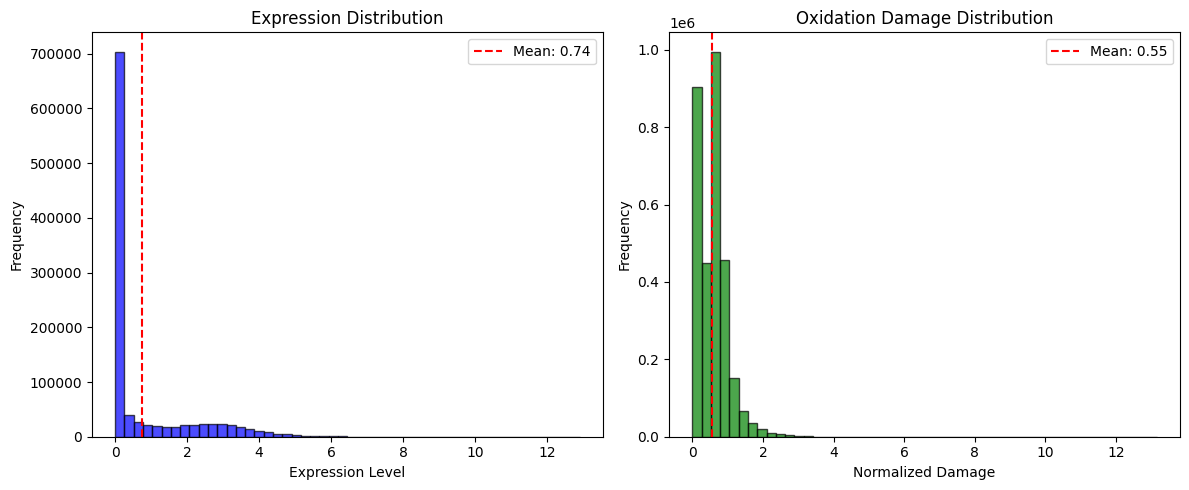

STARTING REAL MOFA ANALYSIS PIPELINE

PREPARING DATA FOR REAL MOFA ANALYSIS
Common groups: ['Ctrl_morning', 'CRS_morning', 'Ctrl_evening', 'CRS_evening']
Common genes: 52,649

Processing group: Ctrl_morning
  Common samples (normalized): 5
  Final shape: 51445 genes, 5 samples
            sample         group
0  05_Ctrl_morning  Ctrl_morning
1  09_Ctrl_morning  Ctrl_morning
2  03_Ctrl_morning  Ctrl_morning
3  01_Ctrl_morning  Ctrl_morning
4  07_Ctrl_morning  Ctrl_morning

Processing group: CRS_morning
  Common samples (normalized): 5
  Final shape: 51445 genes, 5 samples
            sample         group
0  05_Ctrl_morning  Ctrl_morning
1  09_Ctrl_morning  Ctrl_morning
2  03_Ctrl_morning  Ctrl_morning
3  01_Ctrl_morning  Ctrl_morning
4  07_Ctrl_morning  Ctrl_morning

Processing group: Ctrl_evening
  Common samples (normalized): 5
  Final shape: 51445 genes, 5 samples
            sample         group
0  05_Ctrl_morning  Ctrl_morning
1  09_Ctrl_morning  Ctrl_morning
2  03_Ctrl_morning  Ct

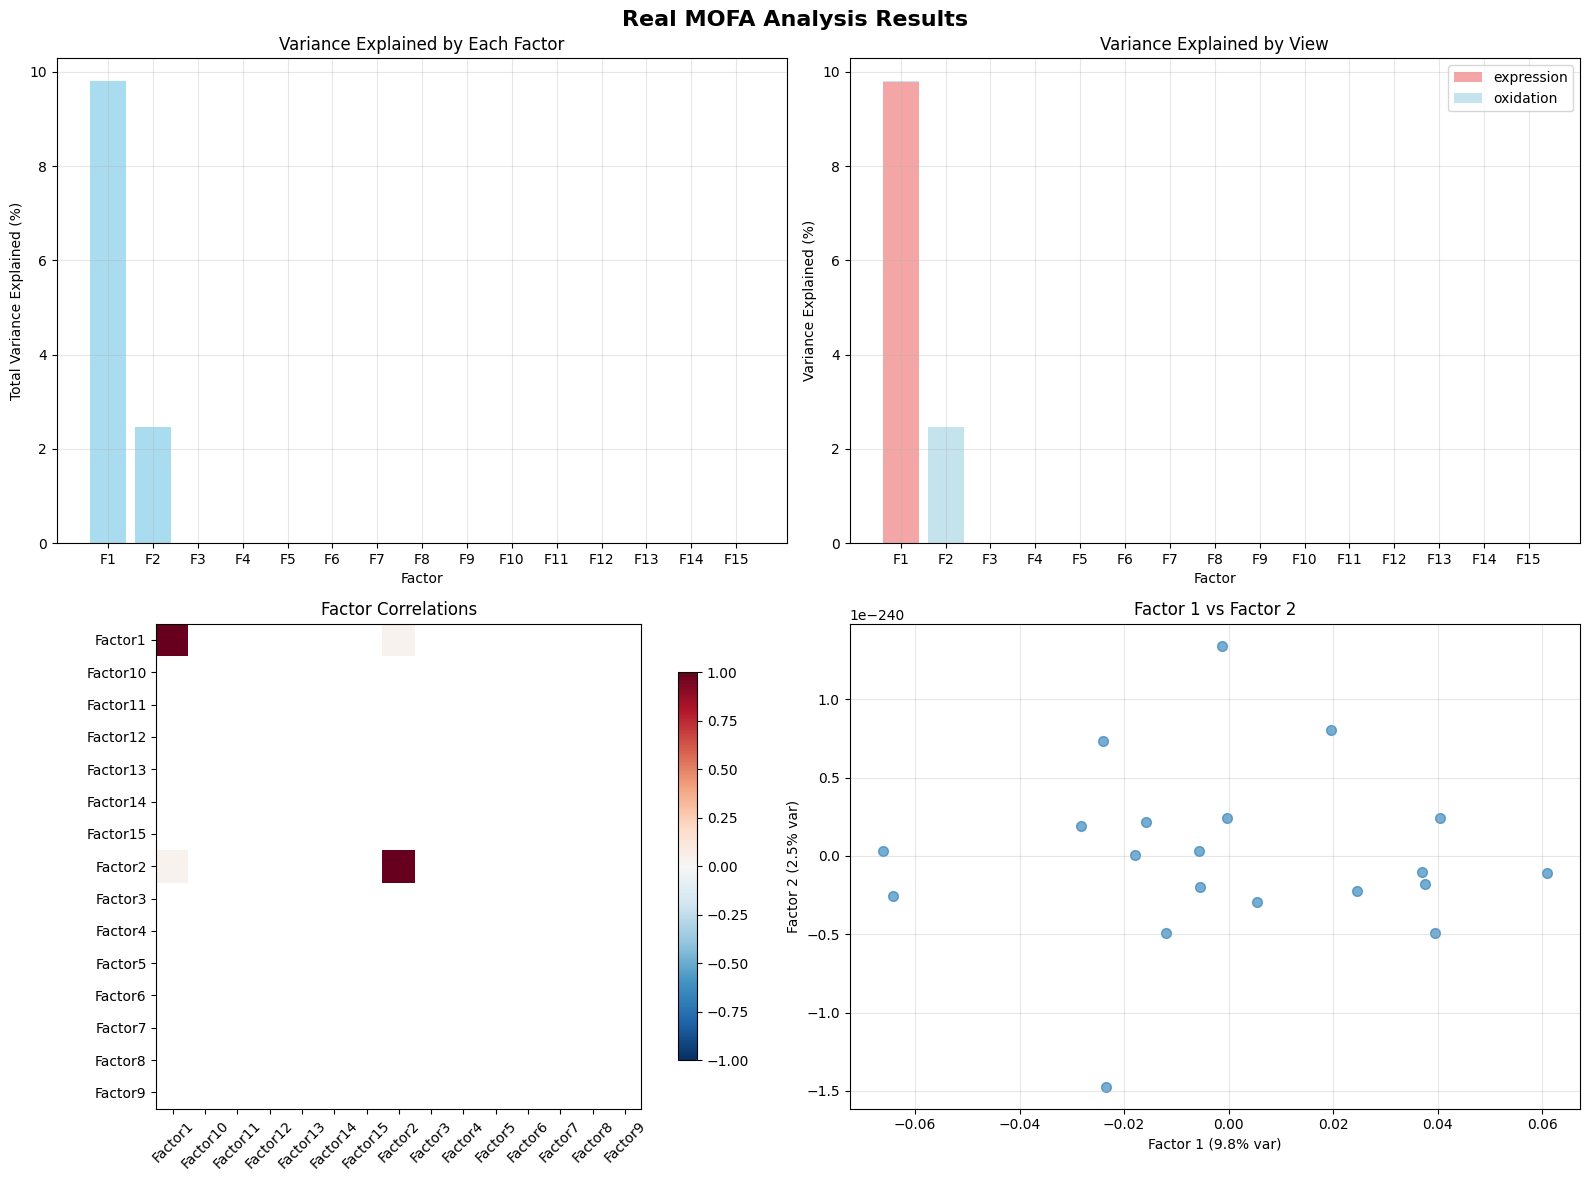


MOFA FACTOR INTERPRETATION

FACTOR1 (9.8% total variance):
--------------------------------------------------
Variance explained by view:
  expression: 9.8%
  oxidation: 0.0%

Top 10 features (by |weight|):
   1. ENSMUSG00000121004 (expression): -6.614
   2. ENSMUSG00000110701 (expression): -6.452
   3. ENSMUSG00000069792 (expression): -6.173
   4. ENSMUSG00000087963 (expression): +5.865
   5. ENSMUSG00000044337 (expression): -5.863
   6. ENSMUSG00000003348 (expression): -5.589
   7. ENSMUSG00000030137 (expression): -5.567
   8. ENSMUSG00000020328 (expression): -5.445
   9. ENSMUSG00000081951 (expression): +5.255
  10. ENSMUSG00000116118 (expression): -5.246

Cross-omics relevance: Low
  Mean |expression weight|: 0.417
  Mean |oxidation weight|: 0.002

FACTOR2 (2.5% total variance):
--------------------------------------------------
Variance explained by view:
  expression: 0.0%
  oxidation: 2.5%

Top 10 features (by |weight|):
   1. ENSMUSG00000119661 (oxidation): -20.121
   2. ENSMU

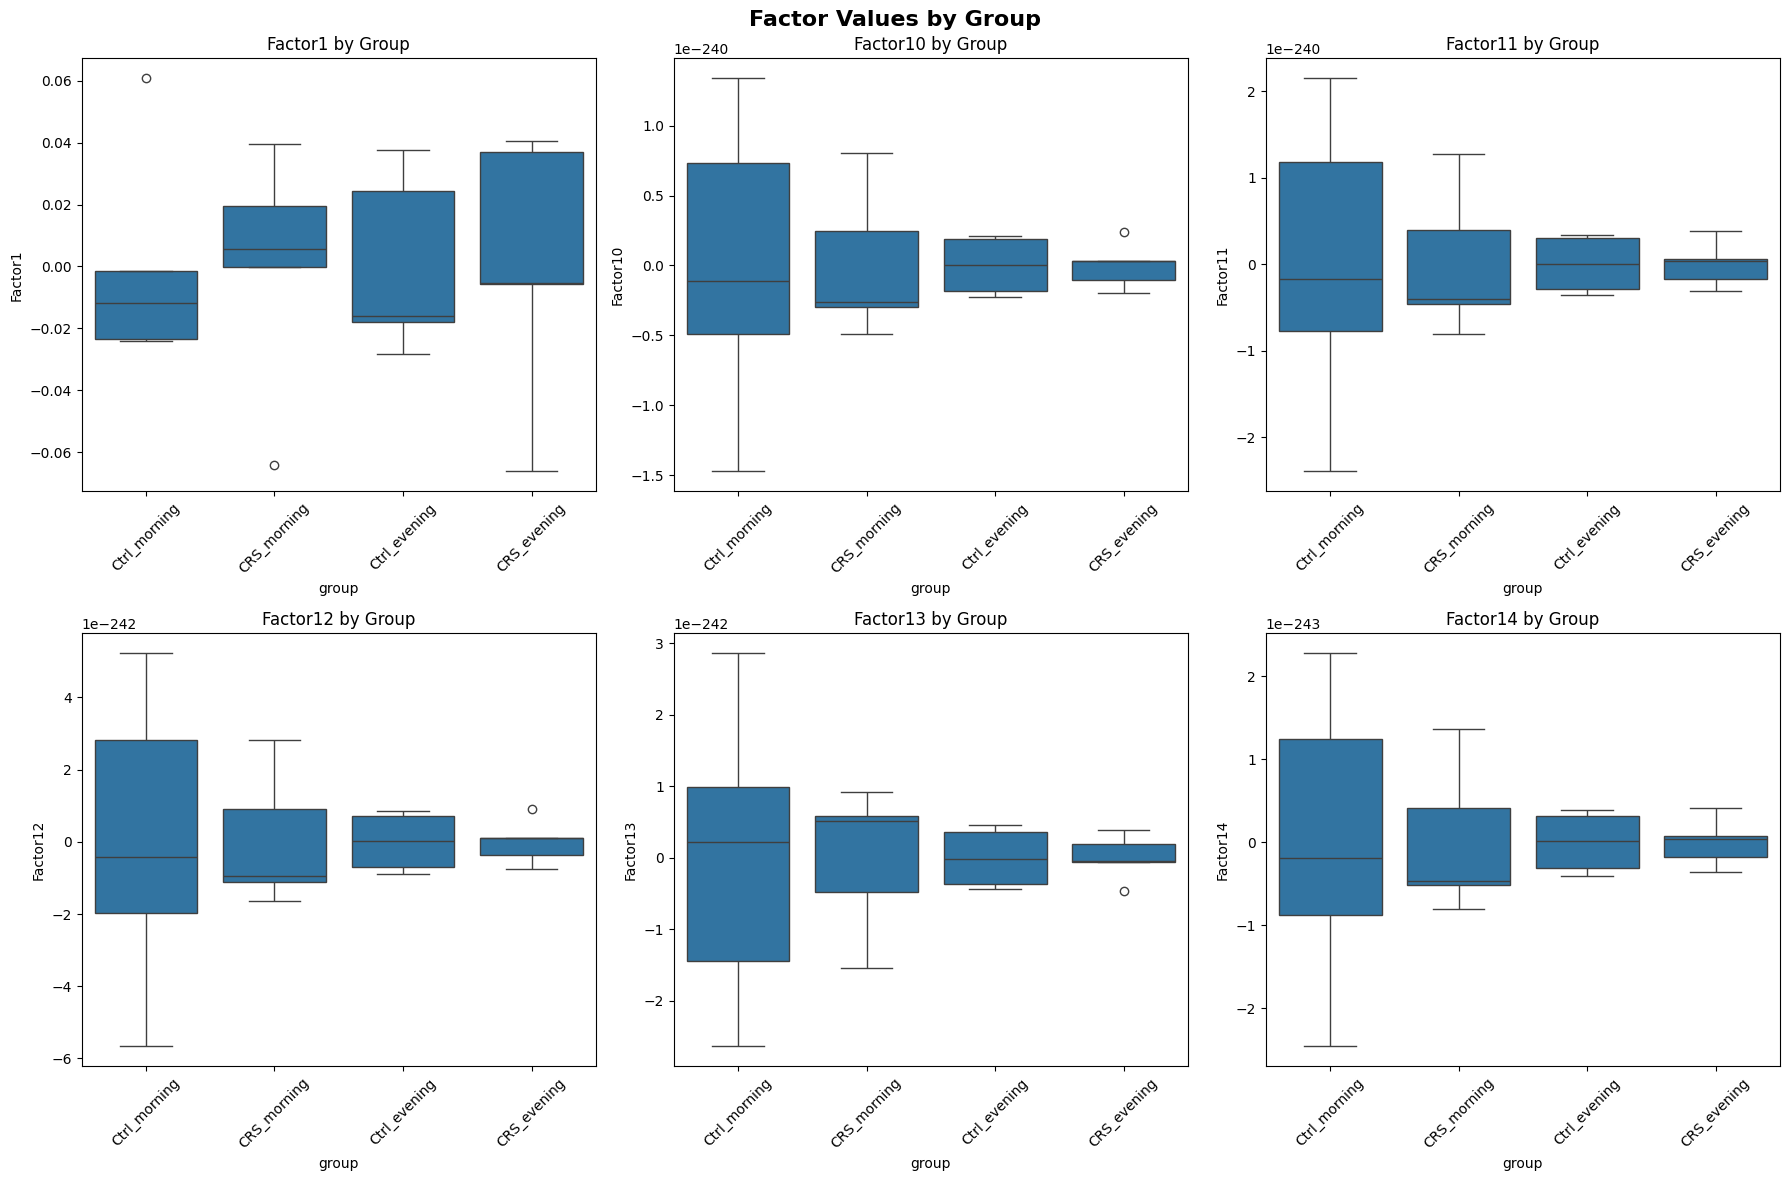


3. PCA ON FACTOR VALUES
--------------------------------------------------
PCA variance explained: [0.85650029 0.14349971 0.        ]
  Saved PCA plot: ../images/mofa_results/only_log/factor_pca_by_group.png


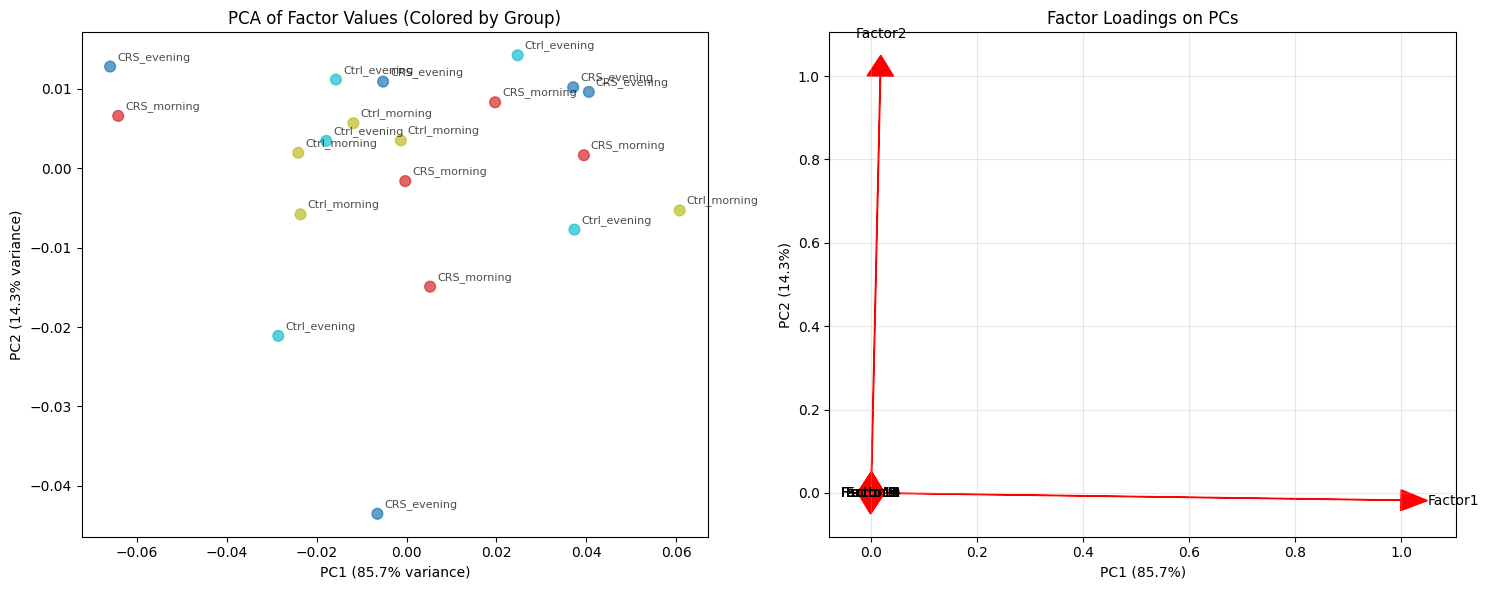


5. ANALYZING FEATURE CONTRIBUTIONS BY GROUP
--------------------------------------------------

Factor1:
  Group-separating: No (P=1.0000)
  Top features:
    ENSMUSG00000121004 (expression): -6.614
    ENSMUSG00000110701 (expression): -6.452
    ENSMUSG00000069792 (expression): -6.173
    ENSMUSG00000087963 (expression): +5.865
    ENSMUSG00000044337 (expression): -5.863
    ENSMUSG00000003348 (expression): -5.589
    ENSMUSG00000030137 (expression): -5.567
    ENSMUSG00000020328 (expression): -5.445
    ENSMUSG00000081951 (expression): +5.255
    ENSMUSG00000116118 (expression): -5.246

Factor10:
  Group-separating: No (P=nan)
  Top features:
    ENSMUSG00000073514 (oxidation): +0.000
    ENSMUSG00000028977 (oxidation): -0.000
    ENSMUSG00000021010 (oxidation): +0.000
    ENSMUSG00000055567 (oxidation): +0.000
    ENSMUSG00000036218 (oxidation): +0.000
    ENSMUSG00000046876 (oxidation): -0.000
    ENSMUSG00000030592 (oxidation): -0.000
    ENSMUSG00000040785 (oxidation): +0.000
  

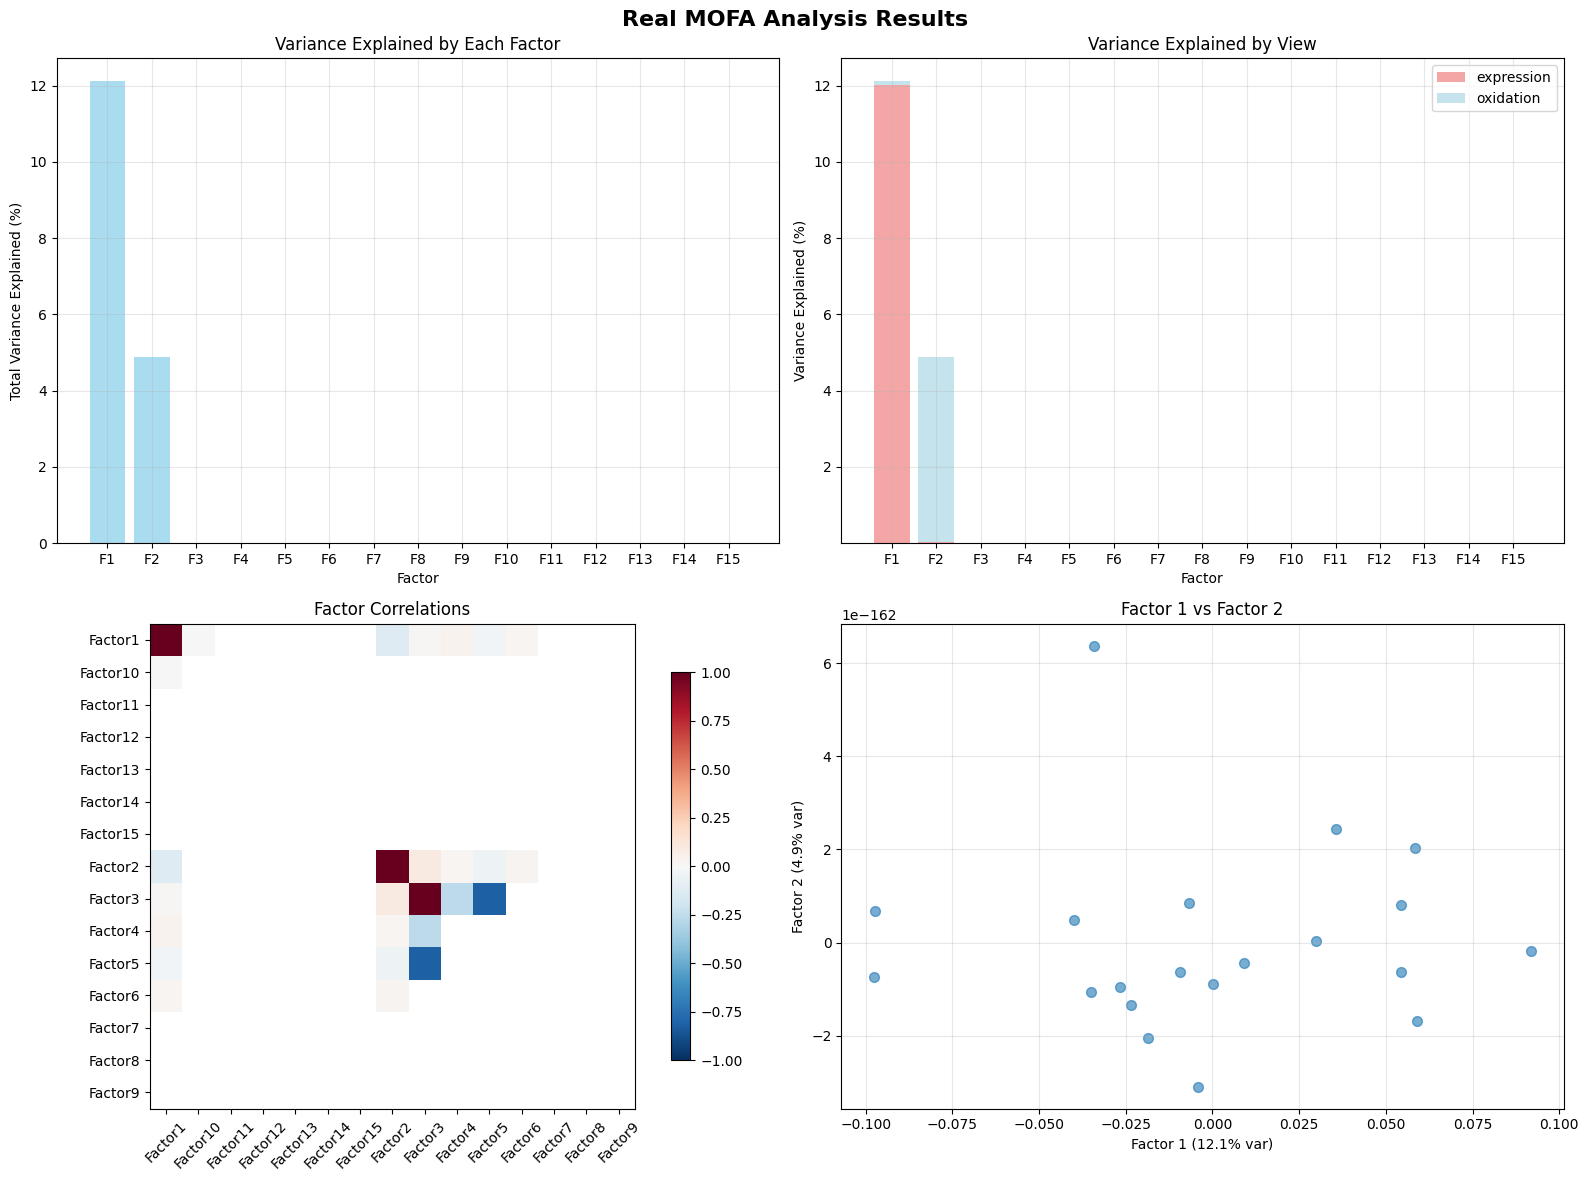


MOFA FACTOR INTERPRETATION

FACTOR1 (12.1% total variance):
--------------------------------------------------
Variance explained by view:
  expression: 12.0%
  oxidation: 0.1%

Top 10 features (by |weight|):
   1. ENSMUSG00000069792 (expression): -3.836
   2. ENSMUSG00000110701 (expression): -3.780
   3. ENSMUSG00000030137 (expression): -3.719
   4. ENSMUSG00000020328 (expression): -3.590
   5. ENSMUSG00000023737 (expression): +3.413
   6. ENSMUSG00000003348 (expression): -3.341
   7. ENSMUSG00000044337 (expression): -3.242
   8. ENSMUSG00000115338 (expression): -3.224
   9. ENSMUSG00000113080 (expression): -3.214
  10. ENSMUSG00000039824 (expression): -3.212

Cross-omics relevance: Low
  Mean |expression weight|: 0.665
  Mean |oxidation weight|: 0.009

FACTOR2 (4.9% total variance):
--------------------------------------------------
Variance explained by view:
  expression: 0.0%
  oxidation: 4.9%

Top 10 features (by |weight|):
   1. ENSMUSG00000020884 (oxidation): -5.710
   2. ENSM

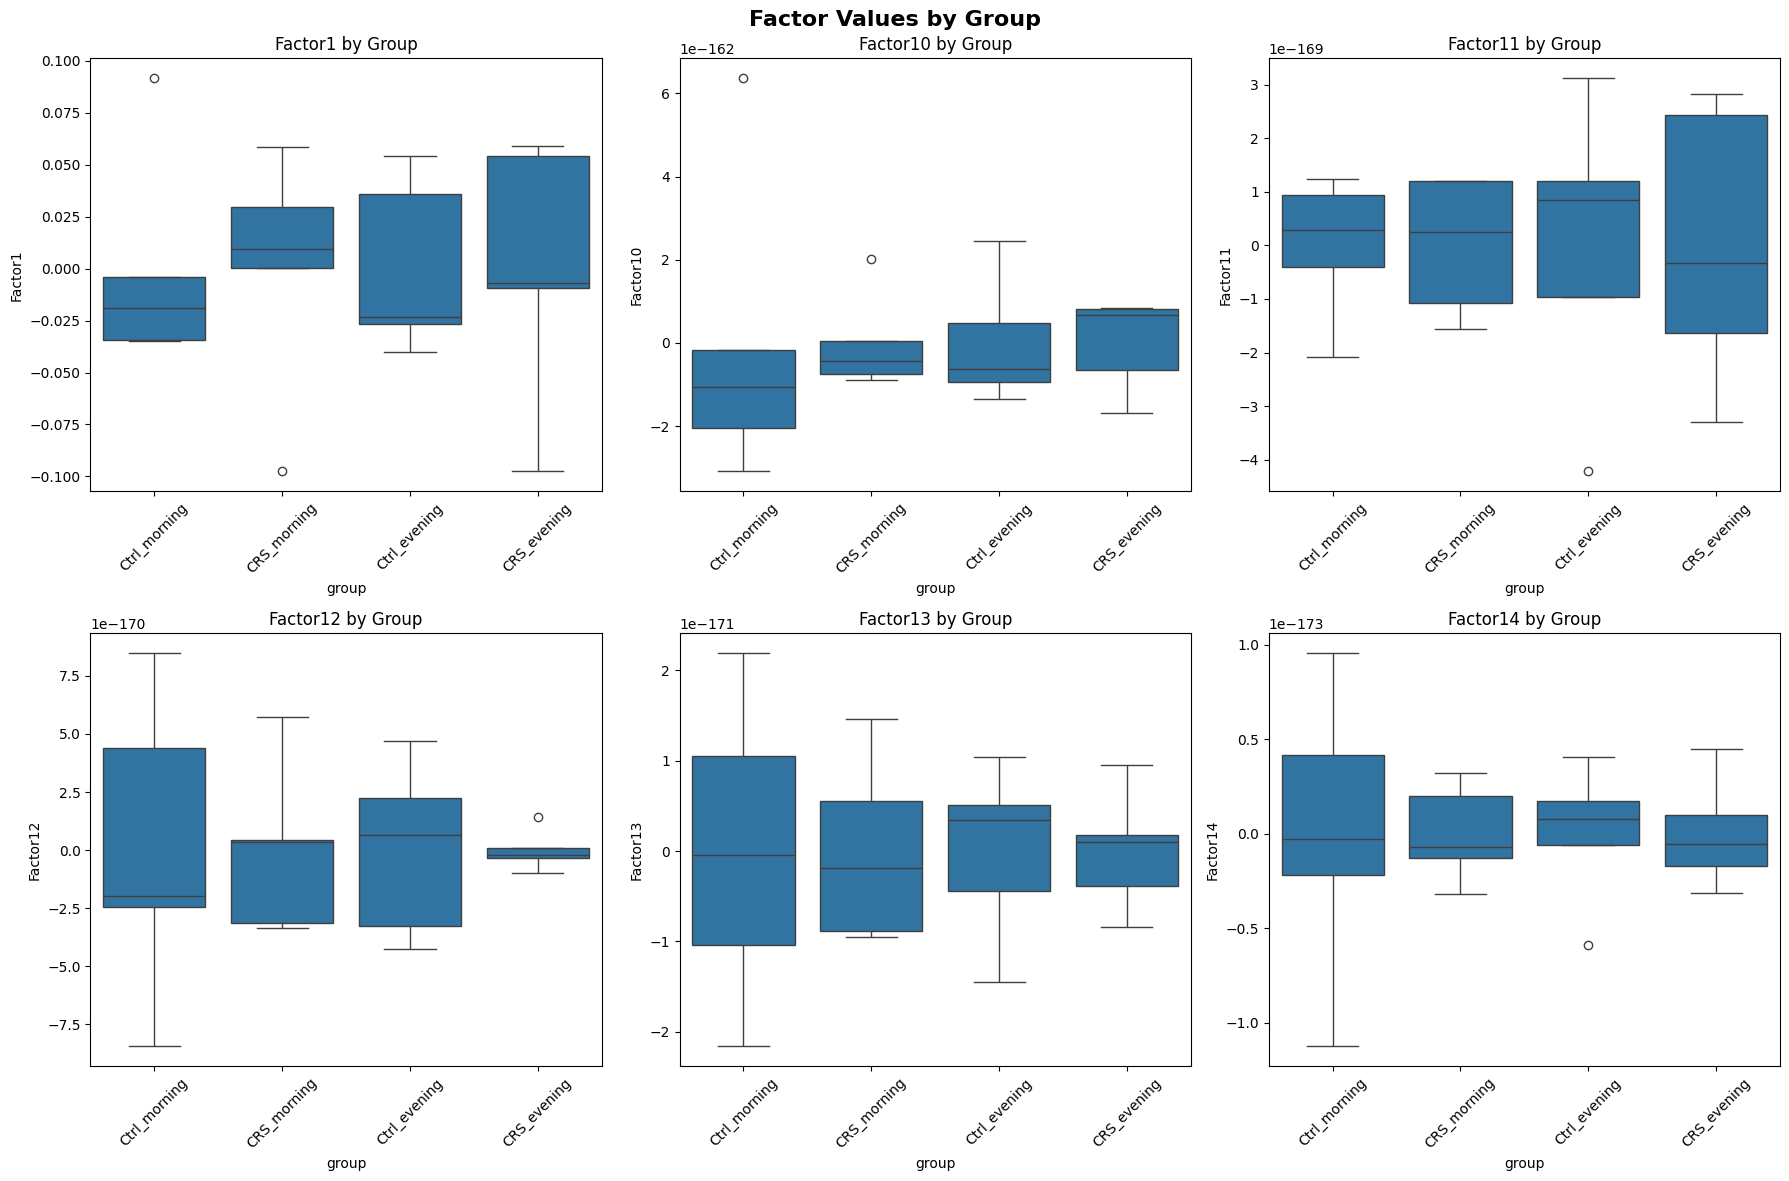


3. PCA ON FACTOR VALUES
--------------------------------------------------
PCA variance explained: [8.72073862e-01 1.27926138e-01 1.62897046e-10]
  Saved PCA plot: ../images/mofa_results/filtered/factor_pca_by_group.png


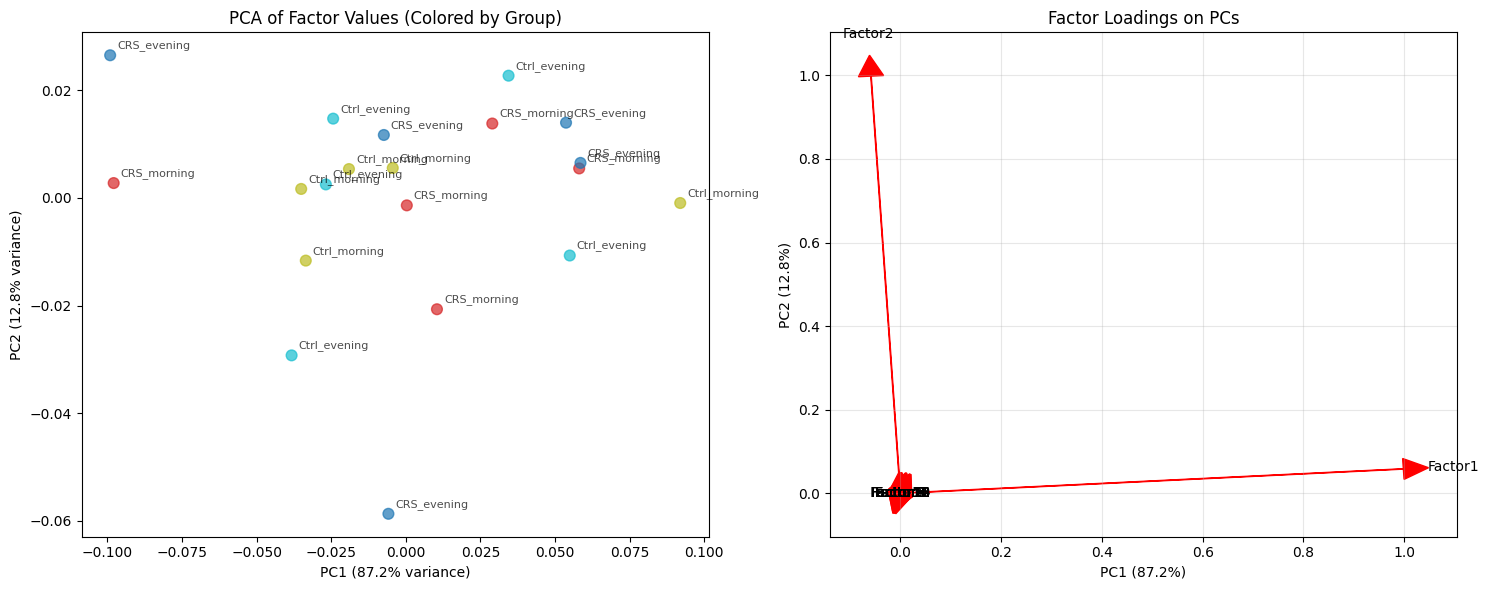


5. ANALYZING FEATURE CONTRIBUTIONS BY GROUP
--------------------------------------------------

Factor1:
  Group-separating: No (P=1.0000)
  Top features:
    ENSMUSG00000069792 (expression): -3.836
    ENSMUSG00000110701 (expression): -3.780
    ENSMUSG00000030137 (expression): -3.719
    ENSMUSG00000020328 (expression): -3.590
    ENSMUSG00000023737 (expression): +3.413
    ENSMUSG00000003348 (expression): -3.341
    ENSMUSG00000044337 (expression): -3.242
    ENSMUSG00000115338 (expression): -3.224
    ENSMUSG00000113080 (expression): -3.214
    ENSMUSG00000039824 (expression): -3.212

Factor10:
  Group-separating: No (P=1.0000)
  Top features:
    ENSMUSG00000090744 (expression): +0.000
    ENSMUSG00000097585 (oxidation): -0.000
    ENSMUSG00000055116 (oxidation): -0.000
    ENSMUSG00000053465 (oxidation): -0.000
    ENSMUSG00000043972 (expression): +0.000
    ENSMUSG00000032352 (oxidation): +0.000
    ENSMUSG00000028565 (oxidation): -0.000
    ENSMUSG00000057816 (oxidation): -0.0

In [96]:
! source ~/mofa_clean_env/bin/activate

EXPR_PATH = "/nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/Vakil/Mouse_brain_Sept2024/gene_annotation2/CRS_Morning_Evening_TPM_rearr.csv"
OXID_PATH = "../data_normalized/gene_bodies_Normalized.csv"

expr_df, oxid_df = load_data(EXPR_PATH, OXID_PATH)

expr_df_log = expr_df.copy()
expr_df_log['Expression_level'] = np.log1p(expr_df['Expression_level'])

oxid_df_log = oxid_df.copy()  
oxid_df_log['median_normalized_damage'] = np.log1p(oxid_df['median_normalized_damage'])

check_mofa_data_distributions(expr_df_log, oxid_df_log)
visualize_distributions(expr_df_log, oxid_df_log)

# For real MOFA (requires mofapy2 installation):
real_mofa_results = run_complete_real_mofa_analysis(expr_df_log, oxid_df_log, "../images/mofa_results/only_log", "../images/mofa_results/filtered")